<a href="https://colab.research.google.com/github/ericdnbn/nn_image_classifier_pneumonia/blob/main/Eric%E2%80%93nn_classifier_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test/' 

In [3]:
!find . -name ".DS_Store" -delete

In [4]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')

In [5]:
train_normal_dir

'chest_xray/train/NORMAL'

In [6]:
len(os.listdir(train_normal_dir))

1242

In [7]:
# get all the data in the directory split/train (542 images), and reshape them
arg_dict = {'target_size':(256, 256), 
            'color_mode':'grayscale', 
            'batch_size':50}

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training')


# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict) 


# get all the data in the directory split/validation (200 images), and reshape them
val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation')


Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [8]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [9]:
train_images[0]

array([[[0.11764707],
        [0.11764707],
        [0.10980393],
        ...,
        [0.10980393],
        [0.10588236],
        [0.10980393]],

       [[0.10980393],
        [0.10980393],
        [0.13725491],
        ...,
        [0.10980393],
        [0.10196079],
        [0.10588236]],

       [[0.11764707],
        [0.09803922],
        [0.15294118],
        ...,
        [0.10196079],
        [0.10588236],
        [0.10588236]],

       ...,

       [[0.15294118],
        [0.16078432],
        [0.1764706 ],
        ...,
        [0.15294118],
        [0.16078432],
        [0.16862746]],

       [[0.15686275],
        [0.15686275],
        [0.17254902],
        ...,
        [0.14901961],
        [0.18039216],
        [0.16470589]],

       [[0.15686275],
        [0.15686275],
        [0.16470589],
        ...,
        [0.14509805],
        [0.16862746],
        [0.14901961]]], dtype=float32)

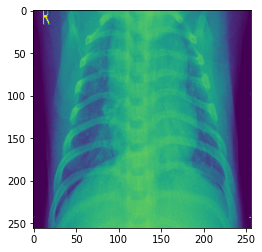

In [10]:
plt.imshow(train_images[3])

In [11]:
train_images.shape[0]

50

In [12]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 50
Number of testing samples: 50
Number of validation samples: 50
train_images shape: (50, 256, 256, 1)
train_labels shape: (50, 2)
test_images shape: (50, 256, 256, 1)
test_labels shape: (50, 2)
val_images shape: (50, 256, 256, 1)
val_labels shape: (50, 2)


In [13]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(50, 65536)
(50, 65536)
(50, 65536)


In [14]:
train_y = np.reshape(train_labels[:,0], (train_images.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_images.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_images.shape[0],1))

print(train_y)
print(test_y)
print(val_y)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]]
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [15]:
# First Simple Model
model = models.Sequential()

In [16]:
model.add(layers.Dense(32, activation='relu', input_shape=(65536,)))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [18]:
history = model.fit(train_img, 
                    train_y,
                    epochs=50,
                    batch_size=10,
                    validation_data=(val_img, val_y))

Epoch 1/50
5/5 [==============================] - 1s 249ms/step - loss: 2.1250 - accuracy: 0.6200 - recall: 0.2727 - val_loss: 0.8292 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 38ms/step - loss: 0.6639 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.6887 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 33ms/step - loss: 0.6772 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.6384 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 30ms/step - loss: 0.5934 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.5461 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 0.5599 - accuracy: 0.7800 - recall: 0.0000e+00 - val_loss: 0.5439 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 26ms/step - loss: 0.5658 

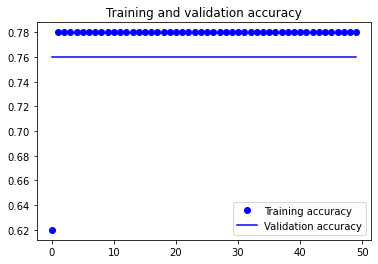

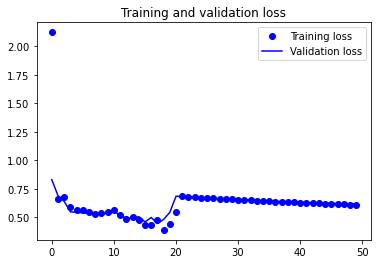

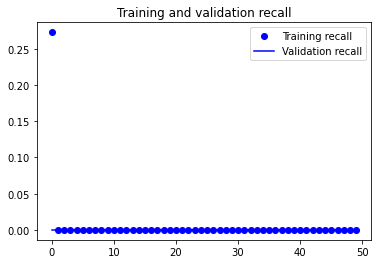

In [19]:

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [20]:
results_train = model.evaluate(train_img, train_y)

2/2 [==============================] - 0s 2ms/step - loss: 0.6073 - accuracy: 0.7800 - recall: 0.0000e+00


In [21]:
results_train

[0.6072872877120972, 0.7799999713897705, 0.0]

In [22]:
results_test = model.evaluate(test_img, test_y)

2/2 [==============================] - 0s 7ms/step - loss: 0.7025 - accuracy: 0.5200 - recall: 0.0000e+00


In [23]:
results_test

[0.7024908661842346, 0.5199999809265137, 0.0]

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
preds = (model.predict(train_img) > 0.5).astype('int32')

cm = confusion_matrix(train_y, preds)

In [26]:
cm

array([[39,  0],
       [11,  0]])

In [27]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Pneumonia'])

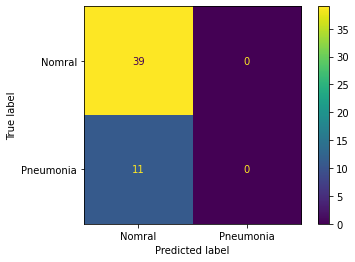

In [28]:
cmd.plot()

In [29]:
from sklearn.utils import class_weight

# Calculate floats/raw class weights
def get_class_weights():

    class_weights = class_weight.compute_class_weight(
                   'balanced',
                    np.unique(train_generator.classes), 
                    train_generator.classes)

# Convert to dict for .fit(class_weight= ) param
    nn_class_weights = {0:class_weights[0],
                        1:class_weights[1]}
    
    return nn_class_weights

In [30]:
def preprocessing_dense_data(train_directory=train_dir,
                             test_directory=test_dir,
                             ts_tuple=(256,256), 
                             color='grayscale', 
                             batch_size=None,
                             process_test=False):

    
    arg_dict = {'target_size':ts_tuple, 
                'color_mode':color, 
                'batch_size':batch_size}

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
       
    train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training') 

    val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation')
    
    
    train_images, train_labels = next(train_generator)
    
    val_images, val_labels = next(val_generator)
    
    
    X_train = train_images.reshape(train_images.shape[0], -1)
    
    X_val = val_images.reshape(val_images.shape[0], -1)
    
    
    y_train = np.reshape(train_labels[:,0], (train_images.shape[0],1))
    
    y_val = np.reshape(val_labels[:,0], (val_images.shape[0],1))
    
    
    return X_train, X_val, y_train, y_val
    
    
    
    
    if process_test:
        
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict, subset='test')
        
        test_images, test_labels = next(test_generator)
        
        X_test = test_images.reshape(test_images.shape[0], -1)
        
        y_test = np.reshape(test_labels[:,0], (test_images.shape[0],1))
        
        return X_test, y_test
    
   
    
    


In [31]:
X_train, X_val, y_train, y_val = preprocessing_dense_data(batch_size=200)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [32]:
model2 = models.Sequential()

In [33]:
model2.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [35]:
history2 = model2.fit(X_train, 
                     y_train,
                     epochs=50,
                     batch_size=10,
                     validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 29ms/step - loss: 1.1415 - accuracy: 0.6750 - recall: 0.2807 - val_loss: 0.5960 - val_accuracy: 0.7250 - val_recall: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 18ms/step - loss: 0.5872 - accuracy: 0.7200 - recall: 0.0702 - val_loss: 0.6793 - val_accuracy: 0.7250 - val_recall: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 21ms/step - loss: 0.6021 - accuracy: 0.7150 - recall: 0.0000e+00 - val_loss: 0.5584 - val_accuracy: 0.8000 - val_recall: 0.2909
Epoch 4/50
20/20 [==============================] - 0s 17ms/step - loss: 0.5582 - accuracy: 0.7000 - recall: 0.0877 - val_loss: 0.4723 - val_accuracy: 0.8250 - val_recall: 0.3818
Epoch 5/50
20/20 [==============================] - 0s 19ms/step - loss: 0.5784 - accuracy: 0.6850 - recall: 0.2456 - val_loss: 0.4490 - val_accuracy: 0.8900 - val_recall: 0.6364
Epoch 6/50
20/20 [==============================] - 0s 17ms/step - loss: 0.4920 - accuracy: 0

In [36]:
def visualize_nn(history, model, X_train, y_train, X_val, y_val):
    acc = history.history['accuracy']
    mean_acc = np.mean(history.history['accuracy'])
    val_acc = history.history['val_accuracy']
    mean_val_acc = np.mean(history.history['val_accuracy'])
    loss = history.history['loss']
    mean_loss = np.mean(history.history['loss'])
    val_loss = history.history['val_loss']
    mean_val_loss = np.mean(history.history['val_loss'])
    recall = history.history['recall']
    mean_recall = np.mean(history.history['recall'])
    val_recall = history.history['val_recall']
    mean_val_recall = np.mean(history.history['val_recall'])

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    plt.show()
    
    
    print(f'Mean Training Accuracy: {mean_acc}')
    print(f'Mean Validation Accuracy: {mean_val_acc}')
    print('')
    print(f'Mean Training Loss: {mean_loss}')
    print(f'Mean Validation Loss: {mean_val_loss}')
    print('')
    print(f'Mean Training Recall: {mean_recall}')
    print(f'Mean Validation Recall: {mean_val_recall}')
    print('')
    print('Training Evaluation:')
    model.evaluate(X_train, y_train)
    print('')
    print('Validation Evaluation:')
    model.evaluate(X_val, y_val)
                                   
    
    
    preds = (model.predict(X_val) > 0.5).astype('int32')
    
    preds2 = (model.predict(X_train) > 0.5).astype('int32')

    cm = confusion_matrix(y_val, preds)
    
    cm2 = confusion_matrix(y_train, preds2)
    
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['Normal', 'Pneumonia'])
    
    print('Validation Confusion Matrix:')
    cmd.plot()
    print('')
    cmd2.plot()
    print('Training Confusion Matrix:');

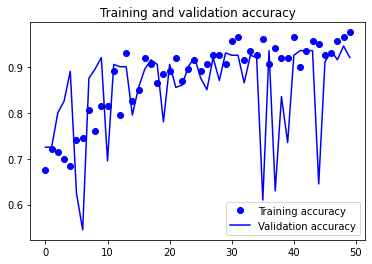

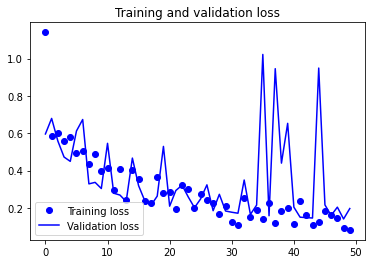

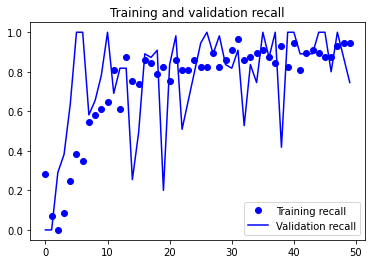

Mean Training Accuracy: 0.8774999976158142
Mean Validation Accuracy: 0.8512000024318696

Mean Training Loss: 0.2903542602062225
Mean Validation Loss: 0.3531558096408844

Mean Training Recall: 0.7431578968465328
Mean Validation Recall: 0.7585454514622688

Training Evaluation:
7/7 [==============================] - 0s 12ms/step - loss: 0.0956 - accuracy: 0.9600 - recall: 0.8596

Validation Evaluation:
7/7 [==============================] - 0s 6ms/step - loss: 0.1961 - accuracy: 0.9200 - recall: 0.7455
Validation Confusion Matrix:

Training Confusion Matrix:


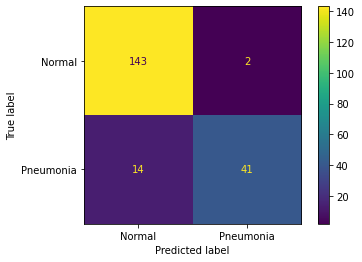

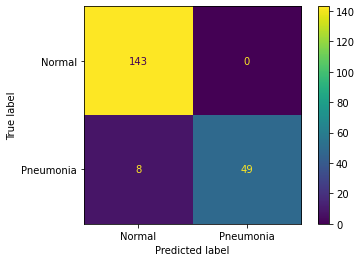

In [37]:
visualize_nn(history2, model2, X_train, y_train, X_val, y_val)

In [38]:
def nn_model(dense_list, 
             input_nodes=64,
             train_directory=train_dir,
             test_directory=test_dir,
             ts_tuple=(256,256), 
             color='grayscale',
             batch_size=1000,
             process_test=False,
             input_activation='relu',
             layer_activation='relu',
             output_activation='sigmoid',
             l2_rate=0.01,
             optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy', 'Recall'],
             epochs=50,
             bs=10):
    
    if not process_test:
        X_train, X_val, y_train, y_val = preprocessing_dense_data(batch_size=batch_size)
    
    else:
        X_train, X_test, X_val, y_train, y_test, y_val = preprocessing_dense_data(batch_size=batch_size)
    
    
    nn_model = models.Sequential()
    
    
    nn_model.add(layers.Dense(int(input_nodes), activation=input_activation, input_shape=(X_train.shape[1],)))
    
    for i, val in enumerate(dense_list):
        nn_model.add(layers.Dense(int(dense_list[i]), 
                                  activation=layer_activation,
                                  kernel_regularizer=l2(l2=l2_rate)))
        
        
    nn_model.add(layers.Dense(1, activation=output_activation))
        
    nn_model.compile(optimizer=optimizer,
                     loss=loss,
                     metrics=metrics)
    
    
    hist = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_val, y_val))
    
    visualize_nn(hist, nn_model, X_train, y_train, X_val, y_val)
    

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 3s 33ms/step - loss: 1.2501 - accuracy: 0.7280 - recall: 0.0272 - val_loss: 1.1260 - val_accuracy: 0.8020 - val_recall: 0.2283
Epoch 2/50
100/100 [==============================] - 2s 24ms/step - loss: 1.0590 - accuracy: 0.7900 - recall: 0.2957 - val_loss: 1.2304 - val_accuracy: 0.5940 - val_recall: 0.9961
Epoch 3/50
100/100 [==============================] - 2s 25ms/step - loss: 0.9859 - accuracy: 0.8160 - recall: 0.5253 - val_loss: 0.8298 - val_accuracy: 0.8980 - val_recall: 0.6929
Epoch 4/50
100/100 [==============================] - 2s 24ms/step - loss: 0.9095 - accuracy: 0.8290 - recall: 0.6148 - val_loss: 0.7736 - val_accuracy: 0.9110 - val_recall: 0.7598
Epoch 5/50
100/100 [==============================] - 2s 24ms/step - loss: 0.8813 - accuracy: 0.8440 - recall: 0.6887 - val_loss: 0.9058 - val_accuracy: 0.8220 - val_recall: 0.9685
Epoch 6/50


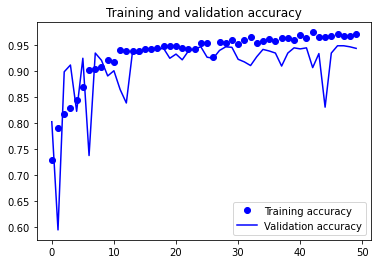

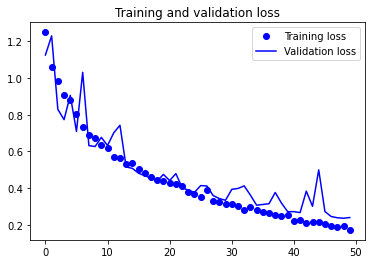

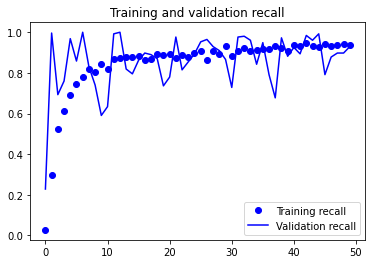

Mean Training Accuracy: 0.9327999997138977
Mean Validation Accuracy: 0.9100600004196167

Mean Training Loss: 0.4458793553709984
Mean Validation Loss: 0.48675849676132205

Mean Training Recall: 0.8456031053885817
Mean Validation Recall: 0.8602362224459648

Training Evaluation:
32/32 [==============================] - 1s 23ms/step - loss: 0.1484 - accuracy: 0.9810 - recall: 0.9572

Validation Evaluation:
32/32 [==============================] - 1s 21ms/step - loss: 0.2398 - accuracy: 0.9430 - recall: 0.9291
Validation Confusion Matrix:

Training Confusion Matrix:


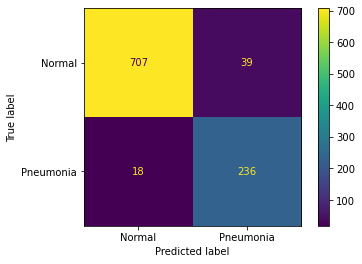

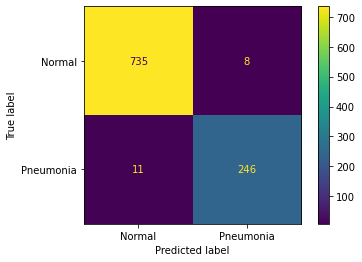

In [39]:
nn_model([32,16],batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 3s 34ms/step - loss: 1.2976 - accuracy: 0.7490 - recall: 0.0000e+00 - val_loss: 1.2382 - val_accuracy: 0.7420 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 3s 28ms/step - loss: 1.2015 - accuracy: 0.7490 - recall: 0.0000e+00 - val_loss: 1.2309 - val_accuracy: 0.7420 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 3s 35ms/step - loss: 1.1357 - accuracy: 0.7390 - recall: 0.0000e+00 - val_loss: 1.1286 - val_accuracy: 0.7420 - val_recall: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 4s 36ms/step - loss: 1.0336 - accuracy: 0.8210 - recall: 0.4382 - val_loss: 0.9813 - val_accuracy: 0.9050 - val_recall: 0.8256
Epoch 5/50
100/100 [==============================] - 4s 37ms/step - loss: 0.9868 - accuracy: 0.8710 - recall: 0.7131 - val_loss: 0.9324 - val_accuracy: 0.8950 - val_re

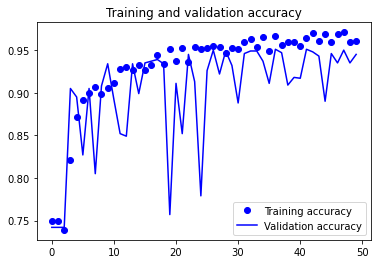

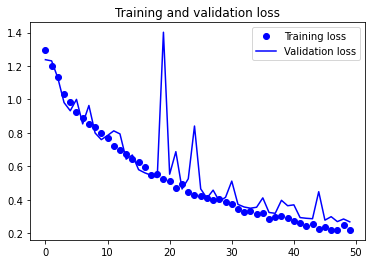

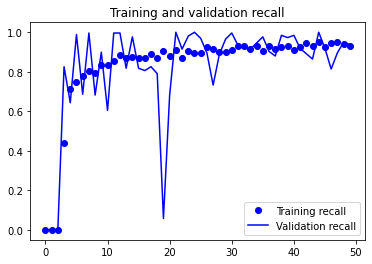

Mean Training Accuracy: 0.9292399966716767
Mean Validation Accuracy: 0.9015399956703186

Mean Training Loss: 0.5257208016514778
Mean Validation Loss: 0.5851973956823349

Mean Training Recall: 0.8279681420326233
Mean Validation Recall: 0.8207751936465502

Training Evaluation:
32/32 [==============================] - 0s 14ms/step - loss: 0.1803 - accuracy: 0.9800 - recall: 0.9761

Validation Evaluation:
32/32 [==============================] - 0s 13ms/step - loss: 0.2676 - accuracy: 0.9450 - recall: 0.9380
Validation Confusion Matrix:

Training Confusion Matrix:


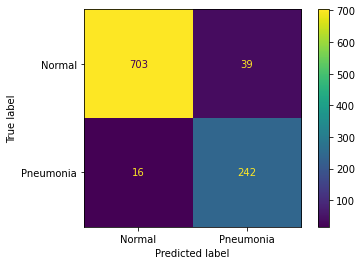

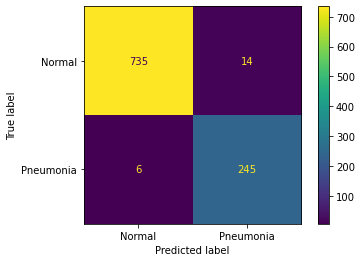

In [40]:
nn_model([32,16,8],batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 3s 28ms/step - loss: 1.3129 - accuracy: 0.7220 - recall: 0.0037 - val_loss: 1.2425 - val_accuracy: 0.7430 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 4s 40ms/step - loss: 1.2470 - accuracy: 0.7240 - recall: 0.0481 - val_loss: 1.1043 - val_accuracy: 0.7430 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 3s 31ms/step - loss: 1.1097 - accuracy: 0.8070 - recall: 0.4222 - val_loss: 1.3966 - val_accuracy: 0.4760 - val_recall: 1.0000
Epoch 4/50
100/100 [==============================] - 4s 35ms/step - loss: 1.0570 - accuracy: 0.8350 - recall: 0.6296 - val_loss: 0.9779 - val_accuracy: 0.8410 - val_recall: 0.4047
Epoch 5/50
100/100 [==============================] - 4s 38ms/step - loss: 0.9418 - accuracy: 0.8890 - recall: 0.7667 - val_loss: 0.9289 - val_accuracy: 0.8670 - val_recall: 0.5136
Epo

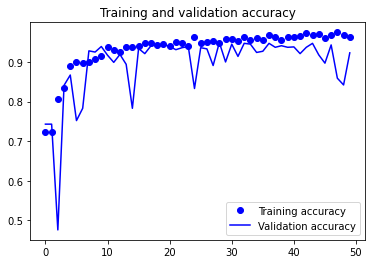

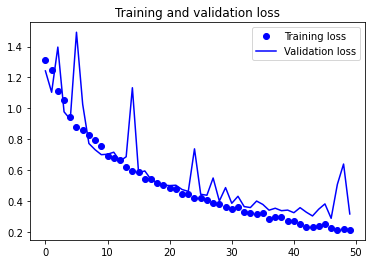

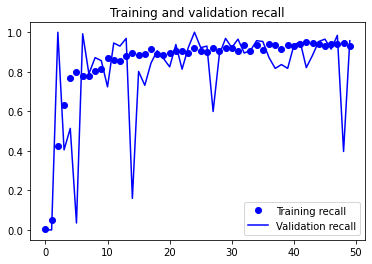

Mean Training Accuracy: 0.9332599997520447
Mean Validation Accuracy: 0.8953599989414215

Mean Training Loss: 0.5096415510773659
Mean Validation Loss: 0.590105203986168

Mean Training Recall: 0.8473333337437361
Mean Validation Recall: 0.7970427950471639

Training Evaluation:
32/32 [==============================] - 0s 14ms/step - loss: 0.1927 - accuracy: 0.9730 - recall: 0.9889

Validation Evaluation:
32/32 [==============================] - 0s 14ms/step - loss: 0.3168 - accuracy: 0.9230 - recall: 0.9572
Validation Confusion Matrix:

Training Confusion Matrix:


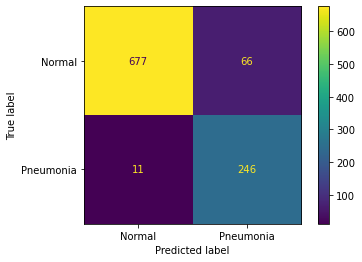

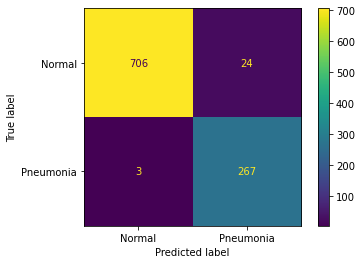

In [41]:
nn_model(dense_list=[32,16,10], batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 5s 45ms/step - loss: 1.0511 - accuracy: 0.7320 - recall: 0.0000e+00 - val_loss: 1.0121 - val_accuracy: 0.7400 - val_recall: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 3s 33ms/step - loss: 1.1012 - accuracy: 0.7320 - recall: 0.0000e+00 - val_loss: 1.0952 - val_accuracy: 0.7400 - val_recall: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 2s 25ms/step - loss: 1.0739 - accuracy: 0.7320 - recall: 0.0000e+00 - val_loss: 1.0497 - val_accuracy: 0.7400 - val_recall: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 3s 30ms/step - loss: 1.0356 - accuracy: 0.7320 - recall: 0.0000e+00 - val_loss: 1.0156 - val_accuracy: 0.7400 - val_recall: 0.0000e+00
Epoch 5/50
100/100 [==============================] - 3s 26ms/step - loss: 1.0060 - accuracy: 0.7320 - recall: 0.0000e+00 - val_loss: 0.9883 - val_accuracy: 0.7

Epoch 44/50
100/100 [==============================] - 3s 26ms/step - loss: 0.3440 - accuracy: 0.9330 - recall: 0.8918 - val_loss: 0.3363 - val_accuracy: 0.9250 - val_recall: 0.7731
Epoch 45/50
100/100 [==============================] - 3s 25ms/step - loss: 0.3340 - accuracy: 0.9300 - recall: 0.8806 - val_loss: 0.3302 - val_accuracy: 0.9340 - val_recall: 0.9308
Epoch 46/50
100/100 [==============================] - 3s 25ms/step - loss: 0.3365 - accuracy: 0.9260 - recall: 0.8769 - val_loss: 0.3302 - val_accuracy: 0.9270 - val_recall: 0.7654
Epoch 47/50
100/100 [==============================] - 3s 26ms/step - loss: 0.2861 - accuracy: 0.9600 - recall: 0.9104 - val_loss: 0.3129 - val_accuracy: 0.9350 - val_recall: 0.8038
Epoch 48/50
100/100 [==============================] - 3s 25ms/step - loss: 0.3146 - accuracy: 0.9320 - recall: 0.8881 - val_loss: 0.3047 - val_accuracy: 0.9360 - val_recall: 0.8308
Epoch 49/50
100/100 [==============================] - 3s 26ms/step - loss: 0.2827 - accur

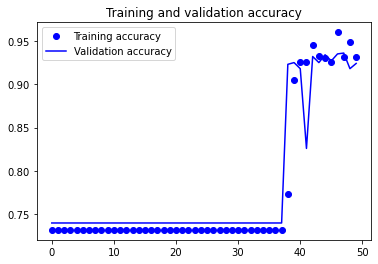

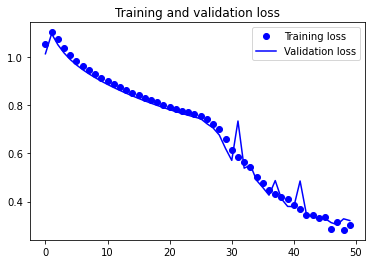

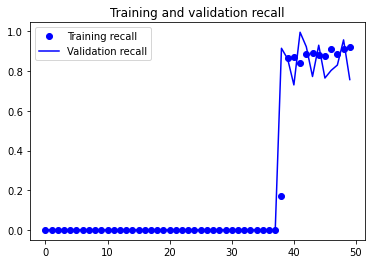

Mean Training Accuracy: 0.7770599937438964
Mean Validation Accuracy: 0.7828600060939789

Mean Training Loss: 0.6845606994628907
Mean Validation Loss: 0.6794489520788193

Mean Training Recall: 0.19828358113765718
Mean Validation Recall: 0.20492307782173158

Training Evaluation:
32/32 [==============================] - 0s 14ms/step - loss: 0.2696 - accuracy: 0.9400 - recall: 0.8060

Validation Evaluation:
32/32 [==============================] - 0s 13ms/step - loss: 0.3215 - accuracy: 0.9240 - recall: 0.7577
Validation Confusion Matrix:

Training Confusion Matrix:


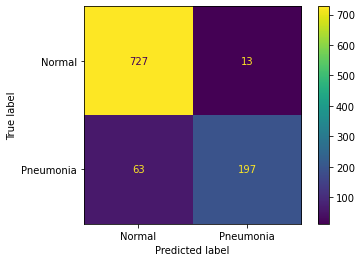

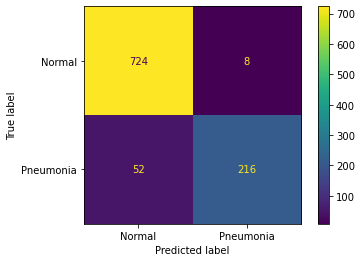

In [42]:
nn_model([16,8,4,2,2],batch_size=1000, ts_tuple=(512,512))

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 3s 30ms/step - loss: 0.6711 - accuracy: 0.7260 - recall: 0.0000e+00 - val_loss: 0.5886 - val_accuracy: 0.7410 - val_recall: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.6382 - accuracy: 0.7160 - recall: 0.0657 - val_loss: 0.6069 - val_accuracy: 0.7410 - val_recall: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - loss: 0.6598 - accuracy: 0.7000 - recall: 0.5146 - val_loss: 0.7495 - val_accuracy: 0.8770 - val_recall: 0.6409
Epoch 4/100
100/100 [==============================] - 3s 29ms/step - loss: 0.7143 - accuracy: 0.8980 - recall: 0.7482 - val_loss: 0.6767 - val_accuracy: 0.8960 - val_recall: 0.7606
Epoch 5/100
100/100 [==============================] - 3s 28ms/step - loss: 0.6107 - accuracy: 0.8500 - recall: 0.6204 - val_loss: 0.4654 - val_accuracy: 0.8920 - val_recall: 0

Epoch 90/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1853 - accuracy: 0.9740 - recall: 0.9416 - val_loss: 0.2304 - val_accuracy: 0.9490 - val_recall: 0.9421
Epoch 91/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1317 - accuracy: 0.9810 - recall: 0.9562 - val_loss: 0.2217 - val_accuracy: 0.9510 - val_recall: 0.9382
Epoch 92/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1205 - accuracy: 0.9790 - recall: 0.9562 - val_loss: 0.3106 - val_accuracy: 0.9360 - val_recall: 0.9807
Epoch 93/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1062 - accuracy: 0.9870 - recall: 0.9708 - val_loss: 0.2630 - val_accuracy: 0.9470 - val_recall: 0.9537
Epoch 94/100
100/100 [==============================] - 2s 25ms/step - loss: 0.1310 - accuracy: 0.9780 - recall: 0.9453 - val_loss: 0.2749 - val_accuracy: 0.9450 - val_recall: 0.9730
Epoch 95/100
100/100 [==============================] - 3s 29ms/step - loss: 0.1598 -

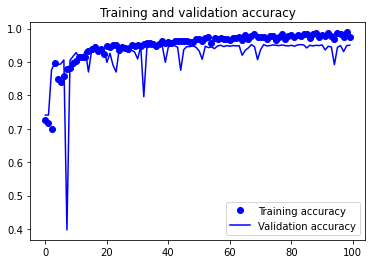

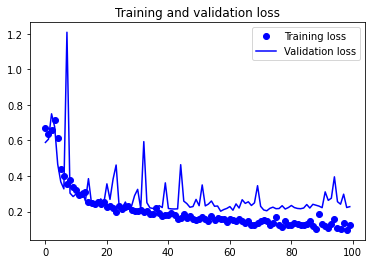

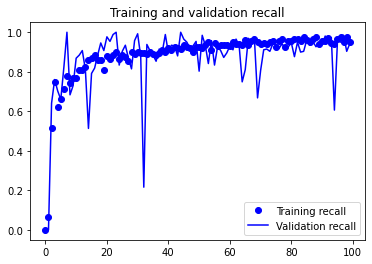

Mean Training Accuracy: 0.948960000872612
Mean Validation Accuracy: 0.9240299999713898

Mean Training Loss: 0.20699022866785527
Mean Validation Loss: 0.2874655038118362

Mean Training Recall: 0.8837226294726134
Mean Validation Recall: 0.8680694986879826

Training Evaluation:
32/32 [==============================] - 1s 16ms/step - loss: 0.0869 - accuracy: 0.9970 - recall: 0.9927

Validation Evaluation:
32/32 [==============================] - 1s 16ms/step - loss: 0.2274 - accuracy: 0.9500 - recall: 0.9421
Validation Confusion Matrix:

Training Confusion Matrix:


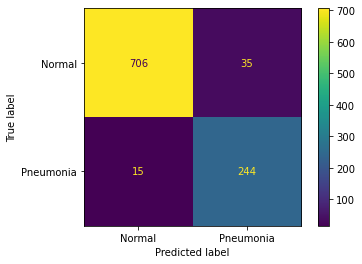

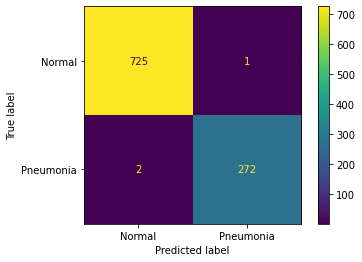

In [43]:
nn_model(dense_list=[32,16,8,4,2], input_nodes=64, batch_size=1000, ts_tuple=(256,256), l2_rate=0.001, epochs=100)

In [45]:
def cnn_preprocessing(train_directory=train_dir,
                      test_directory=test_dir,
                      ts_tuple=(256,256), 
                      color='grayscale', 
                      batch_size=None,
                      process_test=False):

    
    arg_dict = {'target_size':ts_tuple, 
                'color_mode':color, 
                'batch_size':batch_size}

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
       
    train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training', class_mode='binary') 

    val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation', class_mode='binary')
    
    
    
    
    return train_generator, val_generator
    
    
    
    
    if process_test:
        
        
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict, subset='test')

        
        return test_generator
    
   
    
    


In [77]:
def visualize_cnn(history, model, train_generator, val_generator):
    
    #train_images, train_labels = next(train_generator)
    
    #val_images, val_labels = next(val_generator)
    
    
    #X_train = train_images.reshape(train_images.shape[0], -1)
    
    #X_val = val_images.reshape(val_images.shape[0], -1)
    
    
    #y_train = np.reshape(train_labels[:,0], (train_images.shape[0],1))
    
    #y_val = np.reshape(val_labels[:,0], (val_images.shape[0],1))
    
    
    
    acc = history.history['accuracy']
    mean_acc = np.mean(history.history['accuracy'])
    val_acc = history.history['val_accuracy']
    mean_val_acc = np.mean(history.history['val_accuracy'])
    loss = history.history['loss']
    mean_loss = np.mean(history.history['loss'])
    val_loss = history.history['val_loss']
    mean_val_loss = np.mean(history.history['val_loss'])
    recall = history.history['recall']
    mean_recall = np.mean(history.history['recall'])
    val_recall = history.history['val_recall']
    mean_val_recall = np.mean(history.history['val_recall'])

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    plt.show()
    
    
    print(f'Mean Training Accuracy: {mean_acc}')
    print(f'Mean Validation Accuracy: {mean_val_acc}')
    print('')
    print(f'Mean Training Loss: {mean_loss}')
    print(f'Mean Validation Loss: {mean_val_loss}')
    print('')
    print(f'Mean Training Recall: {mean_recall}')
    print(f'Mean Validation Recall: {mean_val_recall}')
    print('')
    print('Training Evaluation:')
    model.evaluate(train_generator)
    print('')
    print('Validation Evaluation:')
    model.evaluate(val_generator)
                                   
    
    
    
    preds = (model.predict(train_generator) > 0.5).astype('int32') 
    
    preds2 = (model.predict(val_generator) > 0.5).astype('int32')

    
    cm = confusion_matrix(val_generator.classes, preds)
    
    cm2 = confusion_matrix(train_generator.classes, preds2)
    
    
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['Normal', 'Pneumonia'])
    
    print('Validation Confusion Matrix:')
    cmd.plot()
    print('')
    cmd2.plot()
    print('Training Confusion Matrix:');

In [78]:
def visualize_cnn_test(history, model, train_generator, val_generator, test_generator):
    
    #train_images, train_labels = next(train_generator)
    
    #val_images, val_labels = next(val_generator)
    
    #test_images, test_labels = next(test_generator)
    
    
    #X_train = train_images.reshape(train_images.shape[0], -1)
    
    #X_val = val_images.reshape(val_images.shape[0], -1)
    
    #X_test = test_images.reshape(test_images.shape[0], -1)
    
    
    #y_train = np.reshape(train_labels[:,0], (train_images.shape[0],1))
    
    #y_val = np.reshape(val_labels[:,0], (val_images.shape[0],1))
    
    #y_test = np.reshape(test_labels[:,0], (test_images.shape[0],1))
    
    
    
    acc = history.history['accuracy']
    mean_acc = np.mean(history.history['accuracy'])
    val_acc = history.history['val_accuracy']
    mean_val_acc = np.mean(history.history['val_accuracy'])
    test_acc = history.history['test_accuracy']
    mean_test_acc = np.mean(history.history['test_accuracy'])
    
    loss = history.history['loss']
    mean_loss = np.mean(history.history['loss'])
    val_loss = history.history['val_loss']
    mean_val_loss = np.mean(history.history['val_loss'])
    test_loss = history.history['test_loss']
    mean_test_loss = np.mean(history.history['test_loss'])
    
    recall = history.history['recall']
    mean_recall = np.mean(history.history['recall'])
    val_recall = history.history['val_recall']
    mean_val_recall = np.mean(history.history['val_recall'])
    test_recall = history.history['test_recall']
    mean_test_recall = np.mean(history.history['test_recall'])

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.plot(epochs, test_acc, 'b', label='Test accuracy')
    plt.title('Training, Validation, and Test accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, test_loss, 'b', label='Test loss')
    plt.title('Training, Validation, and Test loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.plot(epochs, test_recall, 'b', label='test recall')
    plt.title('Training, Validation, and Test recall')
    plt.legend()
    plt.show()
    
    
    print(f'Mean Training Accuracy: {mean_acc}')
    print(f'Mean Validation Accuracy: {mean_val_acc}')
    print(f'Mean Testing Accuracy: {mean_test_acc}')
    print('')
    print(f'Mean Training Loss: {mean_loss}')
    print(f'Mean Validation Loss: {mean_val_loss}')
    print(f'Mean Testing Loss: {mean_test_loss}')
    print('')
    print(f'Mean Training Recall: {mean_recall}')
    print(f'Mean Validation Recall: {mean_val_recall}')
    print(f'Mean Testing Recall: {mean_test_recall}')
    print('')
    print('Training Evaluation:')
    model.evaluate(train_generator)
    print('')
    print('Validation Evaluation:')
    model.evaluate(val_generator)
    print('')
    print('Testing Evaluation:')
    model.evaluate(test_generator)
                                   
    
    
    preds = (model.predict(train_generator) > 0.5).astype('int32')
     
    
    preds2 = (model.predict(val_generator) > 0.5).astype('int32')
    
    
    preds3 = (model.predict(test_generator) > 0.5).astype('int32')                
                    

    
    cm = confusion_matrix(val_generator.classes, preds)
    
    cm2 = confusion_matrix(train_generator.classes, preds2)
    
    cm3 = confusion_matrix(test_generator.classes, preds3)
    
    
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['Normal', 'Pneumonia'])
    
    cmd3 = ConfusionMatrixDisplay(cm3, display_labels=['Normal', 'Pneumonia'])
    
    print('Validation Confusion Matrix:')
    cmd.plot()
    print('')
    cmd2.plot()
    print('Training Confusion Matrix:')
    cmd3.plot();

In [80]:
def specific_cnn_model(filters=32,
              kernel_size=(3,3),
              conv_activation='relu',
              input_shape=(256,256,1),
              pool_size=(2,2),
              conv_kernel_size=(3,3),
              conv_layer_activation='relu',
              input_nodes=512,
              train_directory=train_dir,
              test_directory=test_dir,
              ts_tuple=(256,256), 
              color='grayscale',
              batch_size=50,
              process_test=False,
              input_activation='relu',
              layer_activation='relu',
              normal=False,
              output_activation='sigmoid',
              l2_rate=0.01,
              optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'],
              steps_per_epoch=60,
              epochs=20,
              bs=10,
              validation_steps=20,
              visualize=True):
    
    if not process_test:
        train_generator, val_generator = cnn_preprocessing(batch_size=batch_size)
    
    else:
        test_generator = cnn_preprocessing(batch_size=batch_size)
    
    print('ok')
    
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=conv_layer_activation,
                            input_shape=input_shape))
    cnn_model.add(layers.MaxPooling2D(pool_size))
    cnn_model.add(layers.Conv2D(64, (3, 3), activation=conv_layer_activation))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(128, (3, 3), activation=conv_layer_activation))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(128, (3, 3), activation=conv_layer_activation))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units=input_nodes, activation=layer_activation))
    cnn_model.add(layers.Dense(1, activation=output_activation))

    cnn_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    print('ok')
    
    hist = cnn_model.fit(train_generator, 
                             steps_per_epoch=steps_per_epoch, 
                             epochs=epochs, 
                             batch_size=bs, 
                             validation_data=(val_generator),
                             validation_steps=validation_steps)
    
    
    if visualize:
    
        if process_test:
        
            visualize_cnn_test(hist, cnn_model, train_generator, val_generator, test_generator)
         
        else:
        
            visualize_cnn(hist, cnn_model, train_generator, val_generator)
            
    else:
        
        pass

In [57]:
specific_cnn_model(l2_rate=0.005, optimizer='adam')

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
ok
ok
Epoch 1/20
60/60 [==============================] - 228s 4s/step - loss: 0.4281 - acc: 0.8017 - val_loss: 0.2509 - val_acc: 0.9000
Epoch 2/20
60/60 [==============================] - 221s 4s/step - loss: 0.1503 - acc: 0.9420 - val_loss: 0.1260 - val_acc: 0.9510
Epoch 3/20
60/60 [==============================] - 667s 11s/step - loss: 0.1299 - acc: 0.9518 - val_loss: 0.2078 - val_acc: 0.9020
Epoch 4/20
60/60 [==============================] - 466s 8s/step - loss: 0.0856 - acc: 0.9665 - val_loss: 0.1783 - val_acc: 0.9290
Epoch 5/20
60/60 [==============================] - 590s 10s/step - loss: 0.0850 - acc: 0.9679 - val_loss: 0.1253 - val_acc: 0.9530
Epoch 6/20
60/60 [==============================] - 481s 8s/step - loss: 0.0816 - acc: 0.9689 - val_loss: 0.1088 - val_acc: 0.9620
Epoch 7/20
60/60 [==============================] - 400s 7s/step - loss: 0.0675 - acc: 0.9752 - val_loss: 0.1011 - val_acc

IndexError: too many indices for array

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(train_generator, 
                         steps_per_epoch=50, 
                         epochs=25, 
                         batch_size=10, 
                         validation_data=(val_generator),
                         validation_steps=20)

In [79]:
def cnn_model(cnn_list,
              dense_list,
              filters=32,
              kernel_size=(3,3),
              conv_activation='relu',
              input_shape=(256,256,1),
              pool_size=(2,2),
              conv_kernel_size=(3,3),
              conv_layer_activation='relu',
              input_nodes=512,
              train_directory=train_dir,
              test_directory=test_dir,
              ts_tuple=(256,256), 
              color='grayscale',
              batch_size=50,
              process_test=False,
              input_activation='relu',
              layer_activation='relu',
              normal=False,
              output_activation='sigmoid',
              l2_rate=0.01,
              optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'],
              steps_per_epoch=60,
              epochs=20,
              bs=10,
              validation_steps=20,
              visualize=True):
    
    if not process_test:
        train_generator, val_generator = cnn_preprocessing(batch_size=batch_size)
    
    else:
        train_generator, val_generator, test_generator = cnn_preprocessing(batch_size=batch_size)
    
    print('ok')
    
    cnn_model = models.Sequential()
    
    cnn_model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=conv_layer_activation,
                            input_shape=input_shape))
    
    
    for i, val in enumerate(cnn_list):
        
        if conv_normal:

            
            cnn_model.add(layers.MaxPooling2D(pool_size))
        
            cnn_model.add(layers.Conv2D(cnn_list[i], kernel_size=conv_kernel_size, use_bias=False))
            
            cnn_model.add(layers.BatchNormalization())
            
            cnn_model.add(layers.Activation(con_layer_activation))
            
        else:
            
            cnn_model.add(layers.MaxPooling2D(pool_size))
        
            cnn_model.add(layers.Conv2D(cnn_list[i], kernel_size=conv_kernel_size, activation=conv_layer_activation))
    
    
    cnn_model.add(layers.Flatten())
    
    
    for ind, value in enumerate(dense_list):
    
        
        if normal:
            
            cnn_model.add(layers.Dense(dense_list[ind], use_bias=False, kernel_regularizer=l2(l2=l2_rate)))
            
            cnn_model.add(layers.BatchNormalization())
            
            cnn_model.add(Activation(layer_activation))
        
        
        else:
            
            cnn_model.add(layers.Dense(dense_list[ind], activation=layer_activation, kernel_regularizer=l2(l2=l2_rate)))
        
            
    
    cnn_model.add(layers.Dense(1, activation=output_activation))

    
    cnn_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    print('ok')
    
    hist = cnn_model.fit(train_generator, 
                             steps_per_epoch=steps_per_epoch, 
                             epochs=epochs, 
                             batch_size=bs, 
                             validation_data=(val_generator),
                             validation_steps=validation_steps)
    
    if visualize:
    
        if process_test:
        
            visualize_cnn_test(hist, cnn_model, train_generator, val_generator, test_generator)
         
        else:
        
            visualize_cnn(hist, cnn_model, train_generator, val_generator)
            
    else:
        
        pass
    